# DiffEdit Variation
by John Robinson

Mask Generation using a "Negative Guidance Scale"

This notebook demonstrates an experimental variation to the prompt guided image editing approach covered in the paper, ["DIFFEDIT: DIFFUSION-BASED SEMANTIC IMAGE EDITING WITH MASK GUIDANCE".](https://arxiv.org/abs/2210.11427#)

In the paper, a mask is generated by taking a reference prompt and a target prompt. (eg. referece:'horse',target:'zebra') and generating a noise mask using noise_pred(horse)-noise_pred(zebra).

In this notebook, I've explored a variant.  I noticed that when using noise predictions from the reference and the target to generate the mask, that the mask was often full of "holes".  I hypothesized this was because the noise prediction for the reference and target prompts were too similar in some cases.  What we really want to do is generate a mask that "subtracts out" the reference prompt.  But coming up with another prompt that provides strong "contrast" with the reference prompt is somewhat difficult.  So I wondered what would happen if rather than using the reference and target prompts for the mask generation, what if we used the reference prompt **once with a positive guidance scale and once with a negative guidance** and used those to generate the mask.

It seems to work pretty well!... Although I'm still exploring the results were good enough so that I thought I'd share.



In [1]:
# I used conda with python 3.9

def install_dependencies():
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq --upgrade transformers diffusers ftfy
    !conda install -y -qq ffmpeg

# Uncomment this line if you'd like to install the dependencies. 
#install_dependencies()

## Imports and Setup

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

import cv2

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from torch.nn.functional import threshold

In [4]:
# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

## Authenticate with Hugging Face

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [5]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

## Load Pretrained Hugging Face Models

In [6]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.9.mlp.fc1.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model

In [7]:
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

## Functions to Convert between Latents and Images

In [8]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1);
    latent = latent.latent_dist.sample() * vae_magic      
    return latent

In [9]:
def decode_latent(latents):
    with torch.no_grad():
        return vae.decode(latents/vae_magic).sample

In [10]:
def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

In [11]:
def get_embedding_for_prompt(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt],padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

In [12]:
def generate_noise_pred(prompts, im_latents, seed=32, g=0.15):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text = get_embedding_for_prompt(prompts)
    text_embeddings = torch.cat([uncond, text])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    if im_latents != None:
        # img2img
        #start_step = 10
        start_step = int(num_inference_steps * 0.5)
        timesteps = torch.tensor([scheduler.timesteps[-start_step]],device=torch_device)
        noise = torch.randn_like(im_latents)
        latents = scheduler.add_noise(im_latents,noise,timesteps=timesteps)
        latents = latents.to(torch_device).float()
    else:
        # just text prompts
        start_step = -1 # disable branching below
        latents = torch.randn((1,unet.in_channels,height//8,width//8))#,generator=generator)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma # scale to initial amount of noise for t0

    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timesteps)
    with torch.no_grad():
        u,t = unet(latent_model_input, timesteps, encoder_hidden_states=text_embeddings).sample.chunk(2)
    pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
    pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
    return scheduler.step(pred, timesteps, latents).pred_original_sample

In [13]:
def generate_image_from_embedding(text_embeddings, im_latents, mask=None, seed=None, guidance_scale=0.15):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    if seed is None: seed = torch.seed()
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    
    if im_latents != None:
        # img2img
        start_step = 10
        noise = torch.randn_like(im_latents)
        latents = scheduler.add_noise(im_latents,noise,timesteps=torch.tensor([scheduler.timesteps[start_step]]))
        latents = latents.to(torch_device).float()
    else:
        # just text prompts
        start_step = -1 # disable branching below
        latents = torch.randn((1,unet.in_channels,height//8,width//8))#,generator=generator)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma # scale to initial amount of noise for t0

    noisy_latent = latents.clone()
    # Loop
    noise_pred = None
    for i, tm in tqdm(enumerate(scheduler.timesteps),total=num_inference_steps,desc='Generating Masked Image for Prompt'):
        if i > start_step:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            
            u = noise_pred_uncond
            g = guidance_scale
            t = noise_pred_text

            if g > 0:
                pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
                pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
            else:
                pred = u

            noise_pred = pred
            
            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, tm, latents).prev_sample
            if mask is not None: 
                latents = latents*mask+im_latents*(1.0-mask)

    noise_pred = noisy_latent-latents
    return latents2images(latents)[0],noise_pred

In [14]:
def image2latentmask(im):
    im = tfms.ToTensor()(im).permute(1,2,0)
    m = im.mean(-1) # convert to grayscale
    m = (m > 0.5).float() # binarize to 0.0 or 1.0
    m = cv2.resize(m.cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST)
    m = torch.tensor(m).to(torch_device)
    return m

## Variations on DiffEdit Mask Generation
Rather than taking a reference prompt and a target prompt, this variation on the DiffEdit masking approach takes a single prompt and then uses a positive and a "negative guidance scale" using that same prompt to create a contrastive/negative noise prediction.

In [15]:
# A variation from the diffedit paper
# generate a mask using a single prompt

def generate_mask_variant(encoded,prompt1):
    masks=[]
    n = 20
    for i in tqdm(range(n),desc='Generating Mask for Prompts'):
        s = torch.seed() # Important to use same seed for the two noise samples
        n1 = generate_noise_pred(prompt1,encoded,seed=s,g=0.15)
        n2 = generate_noise_pred(prompt1,encoded,seed=s,g=-0.15)

        i = threshold(decode_latent(n1-n2),0,0)+threshold(decode_latent(n2-n1),0,0)
        masks.append(i.squeeze().mean(axis=0).unsqueeze(dim=0))

#         plt.imshow(masks[-1].squeeze().cpu().numpy(),cmap='gray')
#         plt.show()

    all_masks = torch.cat(masks)
    all_masks = all_masks.sum(axis=0)
    all_masks = all_masks/3
    all_masks = all_masks.clamp(0.,1.)
    return all_masks

def diffedit_variant(im_encoded,from_prompt,to_prompt,seed=None):
    if seed is None: seed = torch.seed()
            
    all_masks = generate_mask_variant(im_encoded,from_prompt)
    
#     plt.imshow(all_masks.cpu().numpy(),cmap='gray')
#     plt.show()
    
    scaled_mask = torch.tensor(cv2.resize((all_masks>=0.5).float().cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST),
                              device=torch_device)
    
#     plt.imshow(scaled_mask.cpu().numpy(),cmap='gray')
#     plt.show()
    
    torch.manual_seed(seed)
    from_emb = get_embedding_for_prompt(from_prompt)
    from_image,from_latent = generate_image_from_embedding(from_emb,im_encoded,seed=seed)
#     plt.imshow(from_image)
#     plt.show()
    
    torch.manual_seed(seed)
    to_emb = get_embedding_for_prompt(to_prompt)
    to_image,to_latent = generate_image_from_embedding(to_emb,im_encoded,scaled_mask,seed=seed)
    
    return to_image

## Demonstrate Mask Generation
Using the "negative guidance scale" approach.

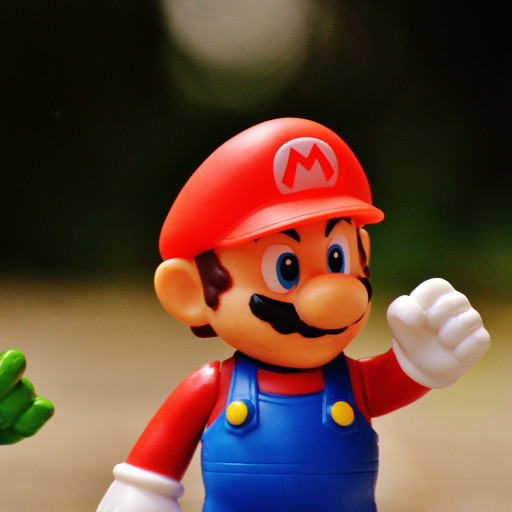

In [16]:
#Load the image
img = Image.open('./images/mario_scaled.jpg').resize((512,512));img

In [17]:
encoded = image2latent(img); encoded.shape

torch.Size([1, 4, 64, 64])

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

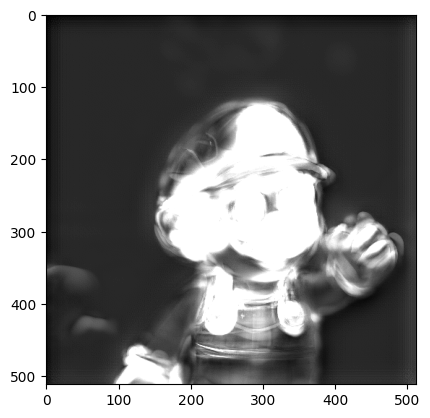

In [18]:
mario_mask = generate_mask_variant(encoded,'Mario')
plt.imshow(mario_mask.cpu().numpy(),cmap='gray')

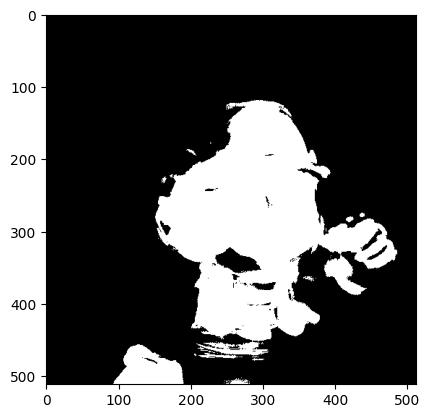

In [19]:
# Show binarized image scale mask (512,512)
plt.imshow((mario_mask>0.5).float().cpu().numpy(),cmap='gray')

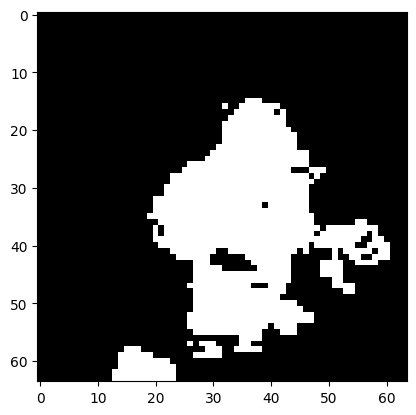

In [20]:
# Scale and show binarized latent scale mask (64,64)
scaled_mask = cv2.resize((mario_mask>=0.5).float().cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST)
plt.imshow(scaled_mask,cmap='gray')

##  Replace Mario with Wario
Inpainting from prompt with mask generation variant

seed: 16321159919113515480


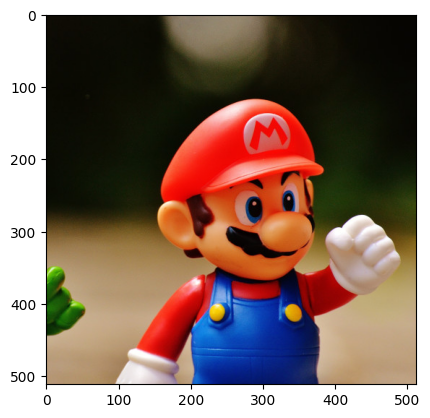

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

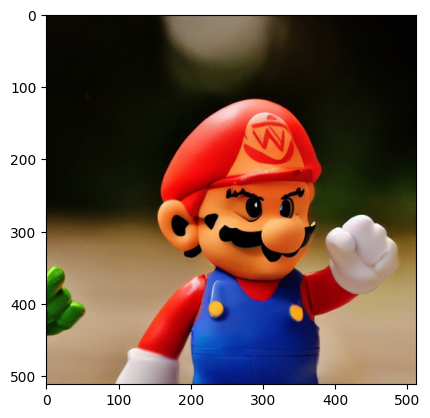

In [21]:
seed = 16321159919113515480
#seed=torch.seed()
print('seed:',seed)
mario_im = Image.open('./images/mario_scaled.jpg')
plt.imshow(mario_im)
plt.show()
mario_en = image2latent(mario_im)
plt.imshow(diffedit_variant(mario_en,'Mario','Wario',seed=seed))
plt.show()

##  Replace a Horse with a Zebra
Inpainting from prompt with mask generation variant

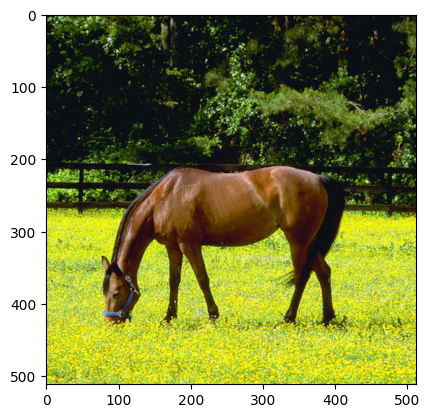

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

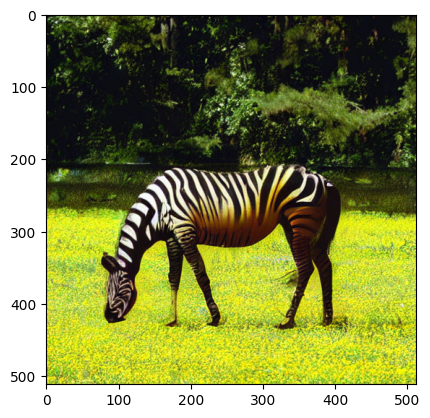

In [22]:
seed = 11794812278352456374
horse_im = Image.open('/home/jr/Documents/horse_scaled.jpg').resize((512,512))
plt.imshow(horse_im)
plt.show()
horse_en = image2latent(horse_im)
plt.imshow(diffedit_variant(horse_en,'a horse image','a zebra image',seed=seed))
plt.show()

##  Replace a Horse with a 'Giraffe'
Inpainting from prompt with mask generation variant

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

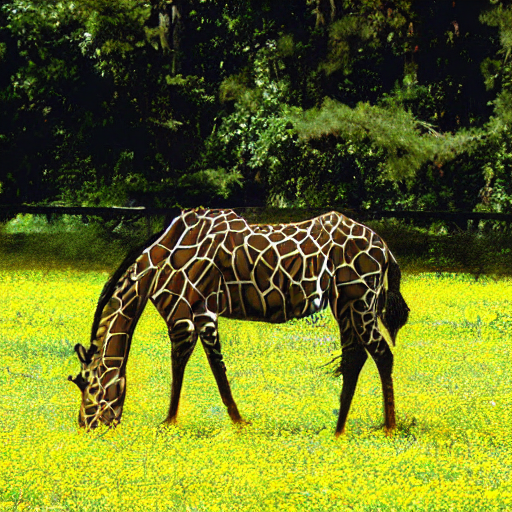

In [23]:
seed = 5327248292640123939
diffedit_variant(horse_en,'a horse image','a giraffe image',seed=seed)

##  Replace Strawberries with Apples
Inpainting from prompt with mask generation variant

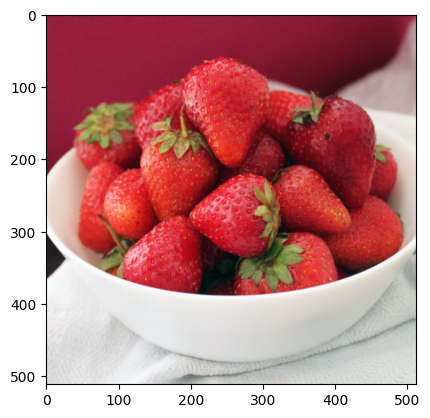

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

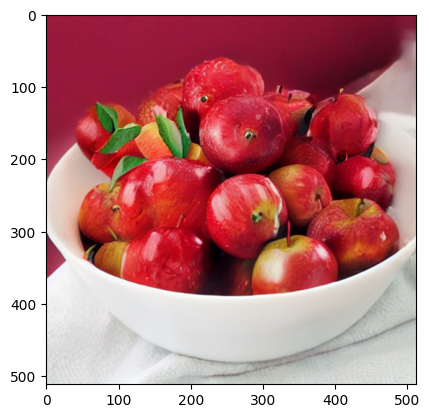

In [24]:
seed = 5327248292640123939
berry_im = Image.open('./images/bowloberries_scaled.jpg')
plt.imshow(berry_im)
plt.show()
berry_en = image2latent(berry_im)
plt.imshow(diffedit_variant(berry_en,'strawberries','apples',seed=seed))
plt.show()